github.com/craffel/theano-tutorial

In [1]:
%matplotlib inline
import theano
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt


Using gpu device 0: GeForce GTX 970


## Basics
### Symbolic variables
In Theano, all algorithms are defined symbolically. It's more like writing out math than writing code. 

In [4]:
# Symbolic computation
foo = T.scalar("foo")
bar = foo ** 2
print(type(bar))
print(bar.type)
print(theano.pp(bar))

<class 'theano.tensor.var.TensorVariable'>
TensorType(float32, scalar)
(foo ** TensorConstant{2})


### Functions
define symbolic functions
theano will compile the function into c code

In [5]:
f = theano.function([foo], bar)
print(f(2))

4.0


In [10]:
# eval method, which takes a dictionary as input
print(bar.eval({foo : 3}))

9.0


In [11]:
# use python function to construct Theano variables
def square(x):
    return x ** 2
bar = square(foo)
print(bar.eval({foo:3}))

9.0


### theano.tensor
support vectors, matrices and tensors

In [14]:
A = T.matrix("A")
x = T.vector('x')
b = T.vector('b')
y = T.dot(A, x) + b

# Squaring matrix is element-wise
z = T.sum(A ** 2)

b_default = np.array([0, 0], dtype=theano.config.floatX)
linear_mix = theano.function([A, x, theano.Param(b, default=b_default)], [y, z])

print(linear_mix(np.array([[1,2,3],
                          [4,5, 6]], dtype=theano.config.floatX), ##A
                 np.array([1,2,3], dtype=theano.config.floatX), ##x
                 np.array([4, 5], dtype=theano.config.floatX) ##b
                ))

print(linear_mix(np.array([[1,2,3],
                          [4,5, 6]], dtype=theano.config.floatX), ##A
                 np.array([1,2,3], dtype=theano.config.floatX) ##x
                ))


[array([ 18.,  37.], dtype=float32), array(91.0, dtype=float32)]
[array([ 14.,  32.], dtype=float32), array(91.0, dtype=float32)]


### Shared variables
Shared varialbes are a little different: they actually do have an explicit value, which can be get/set and is shared across functions which use the variable. They are also useful because they have state across function calls.

In [15]:
shared_var = theano.shared(np.array([[1,2], [3,4]], dtype=theano.config.floatX))
print(shared_var.type)

CudaNdarrayType(float32, matrix)


In [16]:
# set the value of a shared variable using set_value
print(shared_var.get_value())
shared_var.set_value(np.array([[3,4],[2,1]], dtype=theano.config.floatX))
print(shared_var.get_value())

[[ 1.  2.]
 [ 3.  4.]]
[[ 3.  4.]
 [ 2.  1.]]


In [17]:
shared_squared = shared_var ** 2
f1 = theano.function([], shared_squared)
print(f1())

[[  9.  16.]
 [  4.   1.]]


### updates
The value of a shared variable can be updated in a function by using the updates argument of theano.function

In [19]:
# update the state of a shared var in a function
subtract = T.matrix('subtract')
function_2 = theano.function([subtract], shared_var, updates={shared_var: shared_var - subtract})
print(shared_var.get_value())
function_2(np.array([[1,1],[1,1]], dtype=theano.config.floatX))
print(shared_var.get_value())
print(f1())

[[ 3.  4.]
 [ 2.  1.]]
[[ 2.  3.]
 [ 1.  0.]]
[[ 4.  9.]
 [ 1.  0.]]


### Gradients 
Theano can compute gradients


In [20]:
# bar = foo ** 2
# bar_grad = 2 * foo
bar_grad = T.grad(bar, foo)
bar_grad.eval({foo:10})


array(20.0, dtype=float32)

In [25]:
# y = Ax + b 
# compute Jacobian
y_J = theano.gradient.jacobian(y, x)
linear_mix_J = theano.function([A, x, b], y_J)
print(linear_mix_J(np.array([[9,8,7],[4,5,6]], dtype=theano.config.floatX), # A
                   np.array([1,2,3], dtype=theano.config.floatX), #x
                   np.array([4,5], dtype=theano.config.floatX) #b
                  ))
# we can also use theano.gradient.hessian to compute Hessian

[[ 9.  8.  7.]
 [ 4.  5.  6.]]


### Debugging


In [30]:
B = T.matrix('B')
C = T.dot(A,B)

# no shape check in theano
print(C.eval({A:np.zeros((3,4), dtype=theano.config.floatX), B: np.zeros((4,5), dtype=theano.config.floatX)}))




[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


In [103]:
theano.config.compute_test_value='warn'
A.tag.test_value = np.random.random((3,4)).astype(theano.config.floatX)
B.tag.test_value = np.random.random((3,5)).astype(theano.config.floatX)
C = T.dot(A,B)

ValueError: shapes (3,4) and (3,5) not aligned: 4 (dim 1) != 3 (dim 0)

In [113]:
theano.config.compute_test_value='off'

In [35]:
num = T.scalar('num')
den = T.scalar('den')
divide = theano.function([num, den], num/den)
print(divide(10,2))
print(divide(0, 0))


#divide = theano.function([num, den], num/den, mode="DebugMode")
#print(divide(0,0))

5.0
nan


### Using the CPU vs GPU
For gpu:<br>
THEANO_FLAGS=device=gpu,floatX=float32 <br>
For cpu:<br>
THEANO_FLAGS=device=cpu,floatX=float64


In [37]:
print(theano.config.device)
print(theano.config.floatX)

gpu
float32


### Example MLP

In [140]:
class Layer:
    def __init__(self, W_init, b_init, activation):
        n_output, n_input = W_init.shape
        assert b_init.shape == (n_output, )
        
        self.W = theano.shared(value=W_init.astype(theano.config.floatX), name='W', borrow=True) # Allow broadcasting
        self.b = theano.shared(value=b_init.reshape((n_output,1)).astype(theano.config.floatX), name='b', borrow=True, broadcastable=(False, True))
        self.activation = activation
        self.params = [self.W, self.b]
    
    def output(self, x):
        #print(self.W.get_value().shape)
        #print(x.get_value().shape)
        lin_output = T.dot(self.W, x) + self.b
        return (lin_output if self.activation is None else self.activation(lin_output))

In [141]:
class MLP:
    def __init__(self, W_init, b_init, activations):
        assert len(W_init) == len(b_init) == len(activations)
        self.layers=[]
        for W, b, activation in zip(W_init, b_init, activations):
            self.layers.append(Layer(W, b, activation))
        
        self.params = []
        for layer in self.layers:
            self.params += layer.params
    def output(self, x):
        for layer in self.layers:
            x = layer.output(x)
        return x
    
    def squared_error(self, x, y):
        return T.sum((self.output(x) - y) ** 2)
    

### Gradient descent


In [142]:
def gradient_updates_compute(cost, params, learning_rate, momentum):
    assert momentum < 1 and momentum >=0
    updates = []
    for param in params:
        # initialize with 
        param_update = theano.shared(param.get_value() * 0.0, broadcastable=param.broadcastable)
        updates.append((param, param - learning_rate * param_update))
        updates.append((param_update, momentum * param_update + (1.0 - momentum) * T.grad(cost, param)))
    return updates


### Toy Example

/home/alpha/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


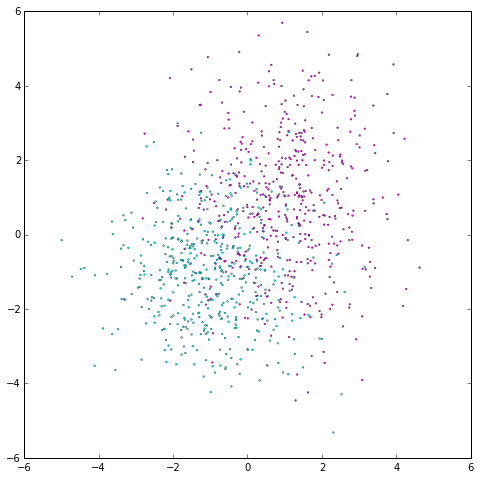

In [45]:
np.random.seed(0)
N = 1000
y = np.random.random_integers(0, 1, N)
means = np.array([[-1, 1], [-1, 1]])

covariances = np.random.random_sample((2,2)) + 1

X = np.vstack([np.random.randn(N) * covariances[0, y] + means[0, y], 
               np.random.randn(N) * covariances[1, y] + means[1, y]]).astype(theano.config.floatX)
y = y.astype(theano.config.floatX)

plt.figure(figsize=(8,8))
plt.scatter(X[0, :], X[1, :], c=y, lw=.3, s=3,cmap=plt.cm.cool)
plt.axis([-6, 6, -6, 6])
plt.show()

In [143]:
layer_sizes = [X.shape[0], X.shape[0] * 2, 1]
W_init = []
b_init = []
activations = []

for n_input, n_output in zip(layer_sizes[:-1], layer_sizes[1:]):
    W_init.append(np.random.randn(n_output, n_input))
    b_init.append(np.ones(n_output))
    activations.append(T.nnet.sigmoid)

layer1 = Layer(W_init[0], b_init[0], activations[0])
mlp = MLP(W_init, b_init, activations)
mlp_input = T.matrix('mlp_input')
mlp_target = T.vector('mlp_target')

learning_rate = 0.01
momentum = 0.9

cost = mlp.squared_error(mlp_input, mlp_target)

train = theano.function([mlp_input, mlp_target], cost, 
                         updates=gradient_updates_compute(cost, mlp.params, learning_rate, momentum))

mlp_output = theano.function([mlp_input], mlp.output(mlp_input))



In [144]:
f3 = theano.function([mlp_input], layer1.output(mlp_input))

In [149]:
f4 = theano.function([mlp_input], mlp.output(mlp_input))

In [145]:
layer1.W.get_value().dot(X) + layer1.b.get_value()
#layer1.b.get_value().shape

array([[ 0.68501788,  1.40537417,  1.90013504, ..., -0.24475479,
         1.42028332,  1.33968127],
       [ 0.25178009,  1.44299948,  3.45057535, ..., -1.96171236,
         2.08407068,  1.67841172],
       [ 1.06239986,  0.60431921,  1.01114285, ...,  1.24363565,
         0.96872985,  0.85477704],
       [ 0.74169707,  1.77887011,  1.46995544, ..., -0.01658106,
         1.27105832,  1.38887477]], dtype=float32)

In [151]:
f4(X).shape

(1, 1000)

In [146]:
f3(X)

array([[ 0.66485769,  0.80303532,  0.86990684, ...,  0.43911496,
         0.80538279,  0.79243749],
       [ 0.56261456,  0.80891865,  0.96924824, ...,  0.12328188,
         0.88934529,  0.8426941 ],
       [ 0.74314886,  0.64664382,  0.73324376, ...,  0.77619624,
         0.72486627,  0.70156831],
       [ 0.67736685,  0.85555726,  0.81305057, ...,  0.49585482,
         0.7809239 ,  0.80041248]], dtype=float32)

/home/alpha/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


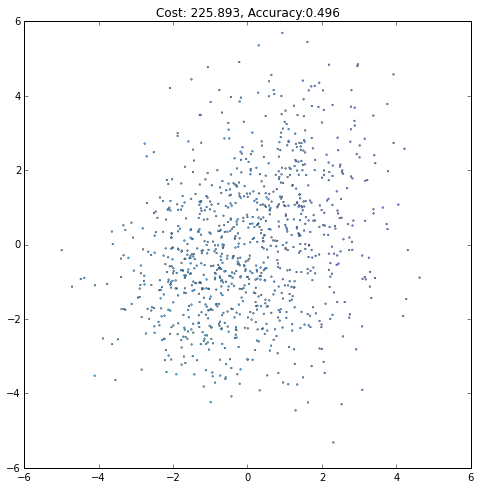

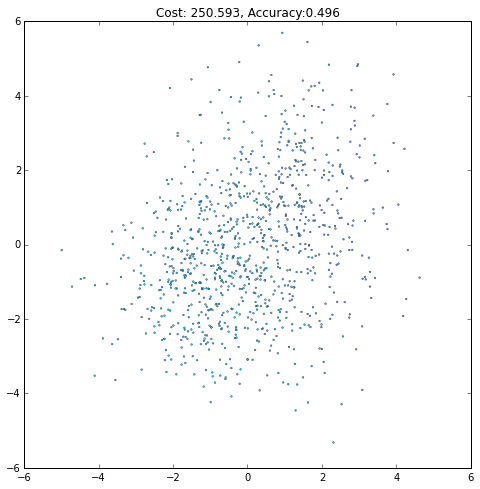

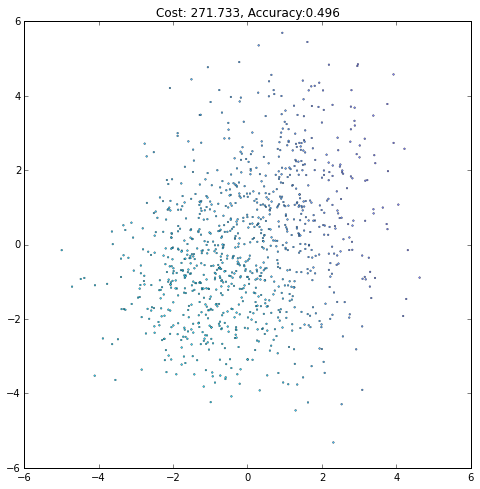

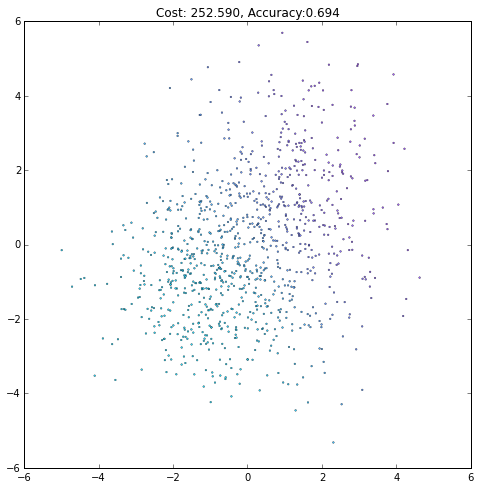

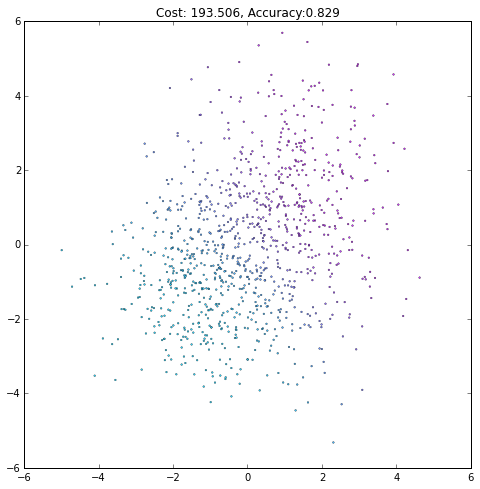

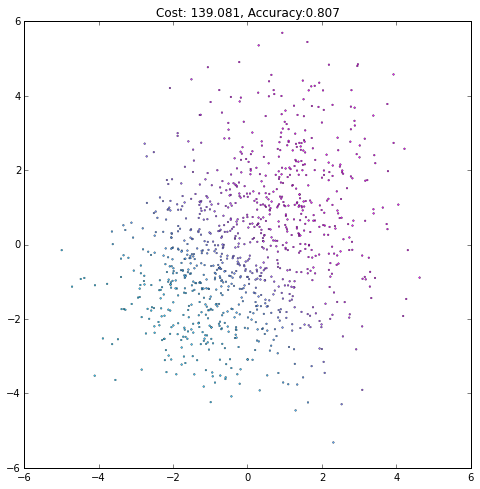

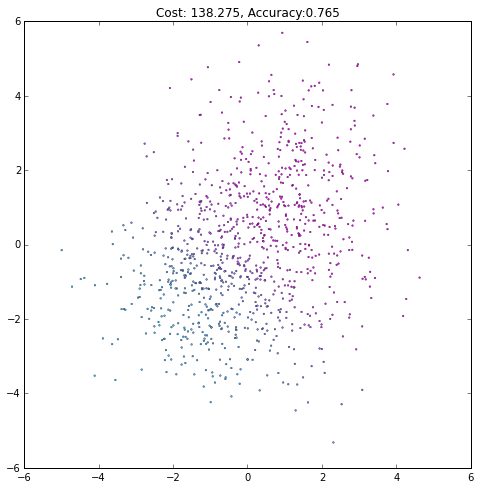

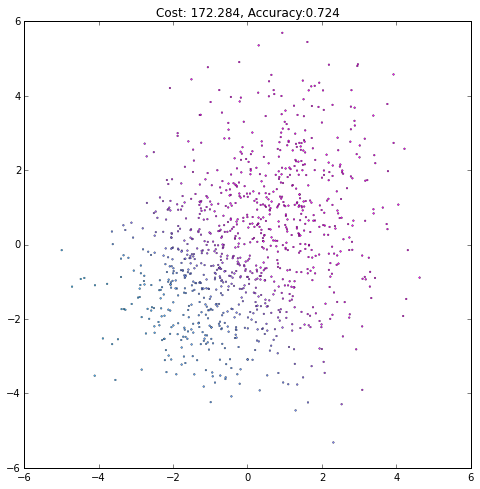

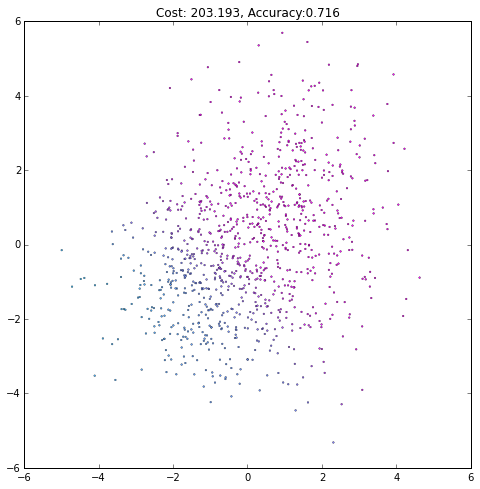

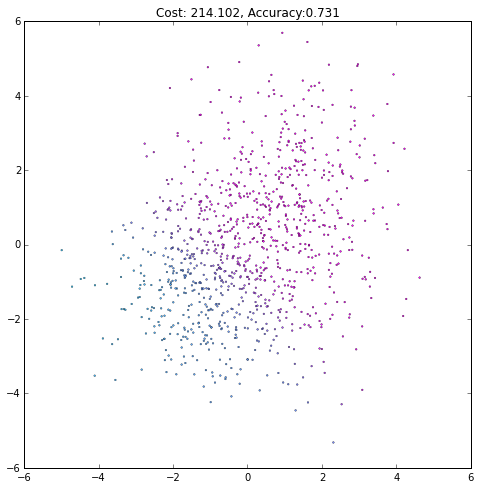

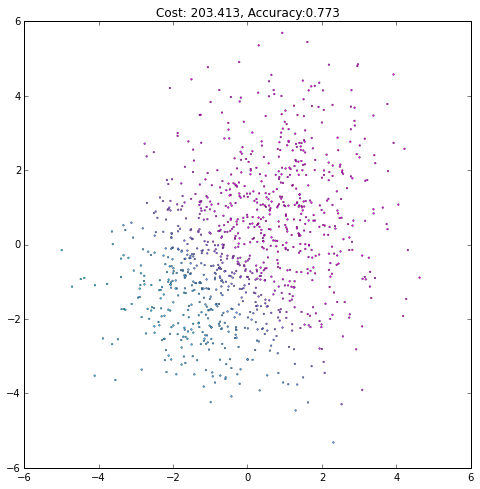

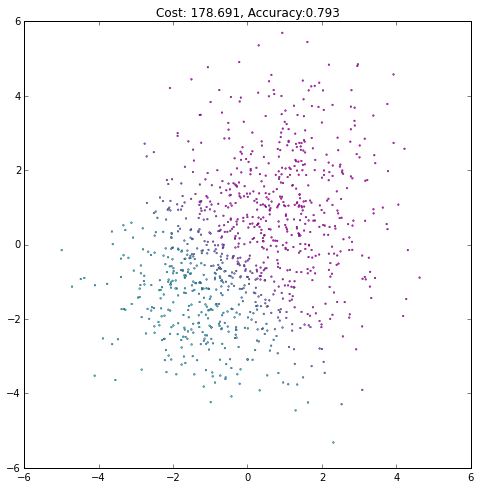

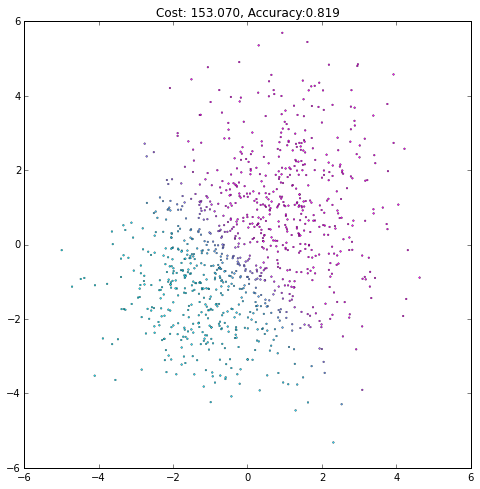

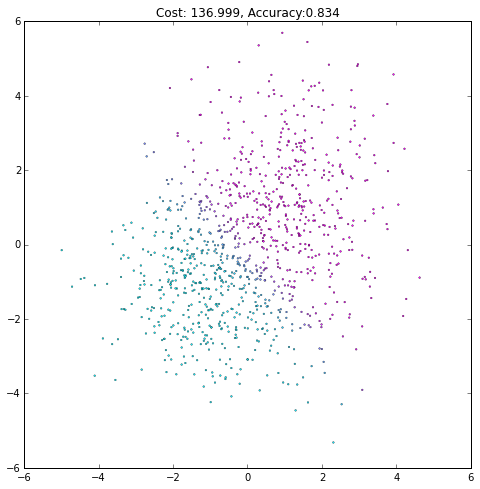

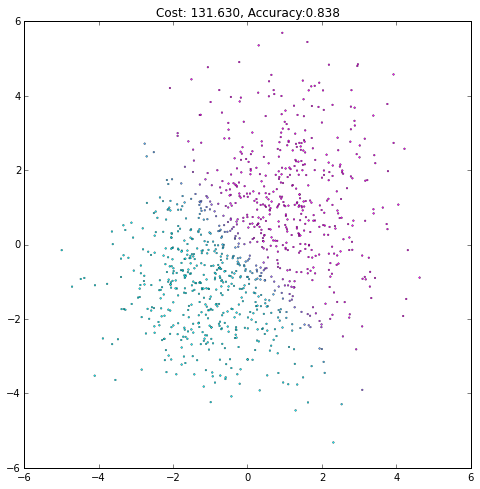

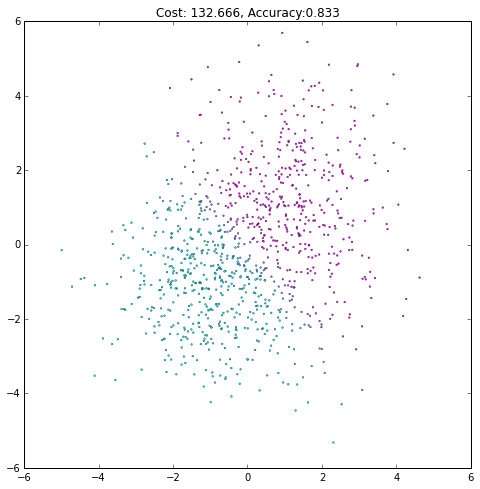

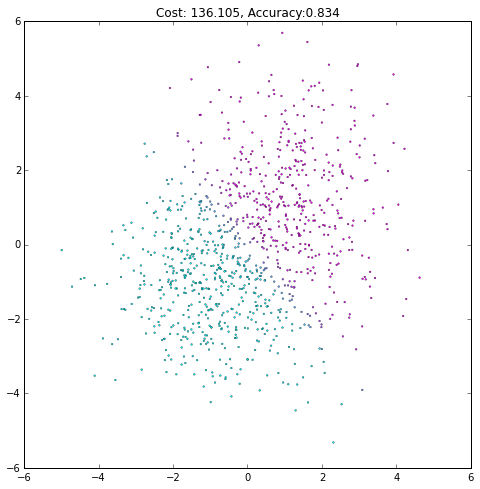

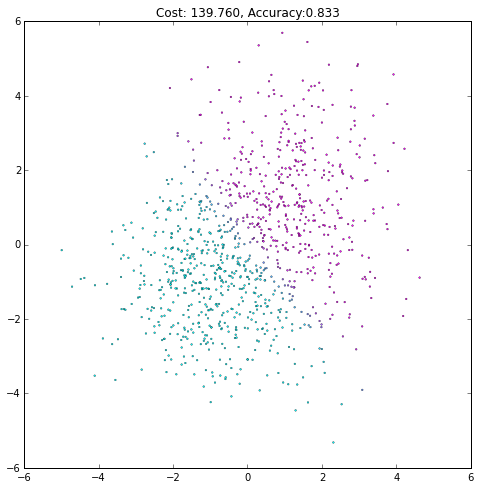

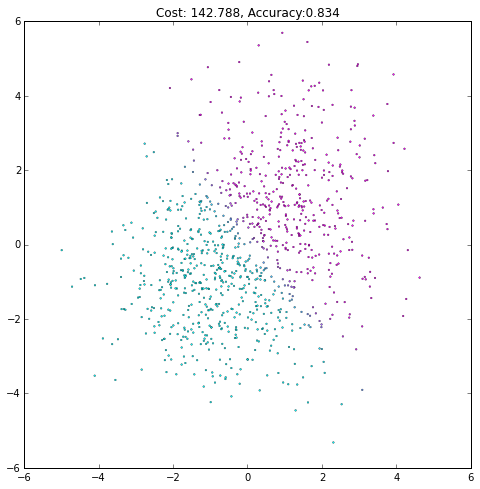

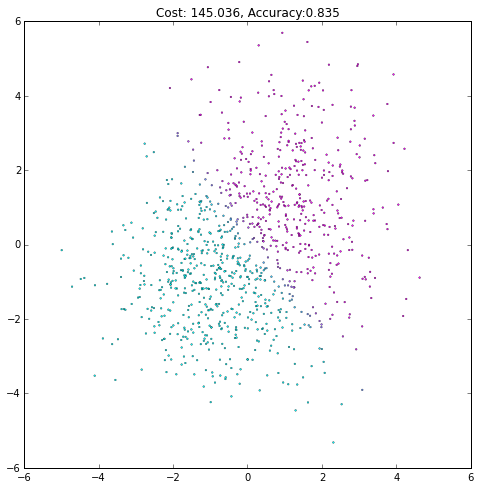

In [154]:
iteration = 0

max_iteration = 20
while iteration < max_iteration:
    current_cost = train(X, y)
    current_output = mlp_output(X)
    #print(current_output)
    accuracy = np.mean((current_output > .5) == y)
    plt.figure(figsize=(8,8))
    plt.scatter(X[0,:], X[1,:], c=current_output, lw=.3, s=3, cmap=plt.cm.cool, vmin=0, vmax=1)
    plt.axis([-6, 6, -6, 6])
    plt.title('Cost: {:.3f}, Accuracy:{:.3f}'.format(float(current_cost), accuracy))
    plt.show()
    iteration += 1

In [105]:
B.eval({B:X}).shape

(2, 1000)

In [57]:
b_init[1].shape == (4, )
b_init[1].shape == (W_init[1].shape[0], )

True

In [74]:
X.shape

(2, 1000)

In [23]:
x.type()

<TensorType(float32, vector)>

In [55]:
W_init

[array([[-0.22612247,  1.92580574],
        [ 1.95176101,  1.23994055],
        [ 0.93858514, -1.01925115],
        [ 0.51256223, -0.3591166 ]]),
 array([[-1.0585719 , -0.50900584,  0.11566507, -0.54735557]])]

In [56]:
b_init

[array([ 1.,  1.,  1.,  1.]), array([ 1.])]